In [ ]:
from google.colab import files
uploaded = files.upload()

Saving taco_sales_(2024-2025).csv to taco_sales_(2024-2025) (8).csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Markdown
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Load dataset and group daily taco orders
df = pd.read_csv("taco_sales_(2024-2025).csv")
df['Order Time'] = pd.to_datetime(df['Order Time'], dayfirst=True)
df['Order Date'] = df['Order Time'].dt.date

# Group by date and count orders
daily_orders = df.groupby('Order Date').size().reset_index(name='Order Count')

# Add 'day-of-week' feature to evaluate "Taco Tuesday" profitability (0 = Monday, 6 = Sunday)
daily_orders['Day of the Week'] = pd.to_datetime(daily_orders['Order Date']).dt.dayofweek

# Normalize both features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_orders[['Order Count', 'Day of the Week']])

In [ ]:
n_input = 31 # Use past 31 days (1 month) for each prediction
X, y = [], []

for i in range(len(scaled_data) - n_input):
  X.append(scaled_data[i:i+n_input])
  y.append(scaled_data[i+n_input][0])

X = np.array(X)
y = np.array(y)

# Reshape input
print("Input shape:", X.shape)

Input shape: (401, 31, 2)


In [ ]:
# Build RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(n_input, 2)))
model.add(Dense(1))

# Compile and train
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0613
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0504
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0399
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0438
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0406
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0458
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0456
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0411
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0452
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0372
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0394
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0434
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0376
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0432
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0381
Epoch 16/50
13/13 ━━━━━━━

In [ ]:
# Use the most recent 31 days to predict the next day
last_seq = scaled_data[-n_input:]
last_seq = last_seq.reshape((1, n_input, 2))
next_day_scaled = model.predict(last_seq)

# Inverse transformation
pad = np.array([[0]])
next_day_full = np.hstack([next_day_scaled, pad])
next_day_forecast = scaler.inverse_transform(next_day_full)[0][0]

print(f"Predicted taco orders for next day: {next_day_forecast:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predicted taco orders for next day: 2.49


##**Final Model Evaluation**##

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


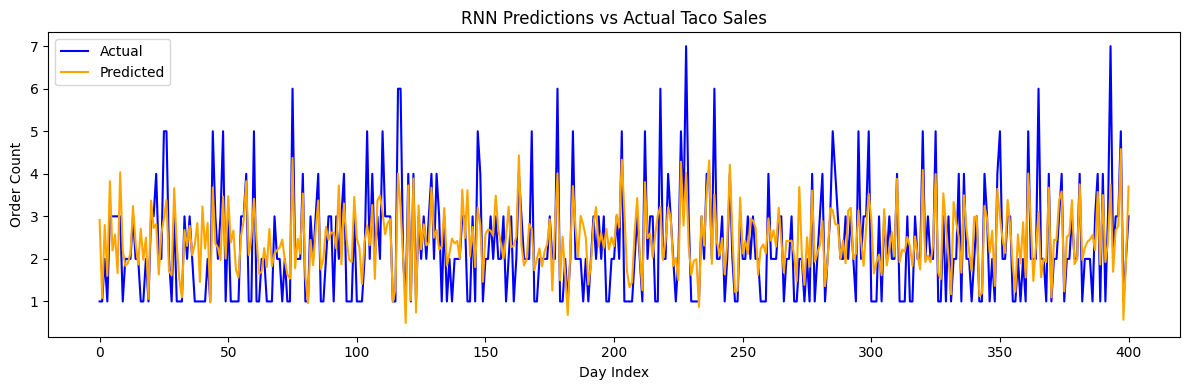

In [ ]:
# Predict over training data
y_pred = model.predict(X)

pad = np.zeros_like(y_pred)
y_pred_full = np.hstack([y_pred, pad])
y_actual_full = np.hstack([y.reshape(-1,1), pad])

# Inverse scale both
y_pred_rescaled = scaler.inverse_transform(y_pred_full)[:, 0]
y_actual_rescaled = scaler.inverse_transform(y_actual_full)[:, 0]

# Plot actual vs predicted
plt.figure(figsize=(12, 4))
plt.plot(y_actual_rescaled, label="Actual", color="blue")
plt.plot(y_pred_rescaled, label="Predicted", color="orange")
plt.title("RNN Predictions vs Actual Taco Sales")
plt.xlabel("Day Index")
plt.ylabel("Order Count")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(y_actual_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_actual_rescaled, y_pred_rescaled))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.70
Root Mean Squared Error (RMSE): 0.91


In [ ]:
# Calculate average order count per day of the week
weekday_avg = daily_orders.groupby('Day of the Week')['Order Count'].mean().reset_index()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_avg['Day'] = weekday_avg['Day of the Week'].apply(lambda x: weekday_labels[x])
weekday_avg = weekday_avg[['Day', 'Order Count']]
weekday_avg = weekday_avg.rename(columns={'Order Count': 'Average Orders'})
weekday_avg = weekday_avg.round(2)

# Calculate mean order count in a single day
mean_value = daily_orders['Order Count'].mean()

# Display results
display(weekday_avg)
print(f"\nMean Order Count: {mean_value:.2f}")

,Day,Average Orders
0,Mon,2.49
1,Tue,2.30
2,Wed,2.44
3,Thu,2.06
4,Fri,2.34
5,Sat,2.25
6,Sun,2.29



Mean Order Count: 2.31
